In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [2]:
import tensorflow as tf
tf.__version__

'1.9.0'

In [3]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
import numpy as np

In [4]:
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('flatten_1').output)

102858752/102853048 [==============================] - 21s 0us/step


In [5]:
img_path = '/work/data/images/71017330.jpg'

In [6]:
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

feature = model.predict(x)

In [7]:
feature.shape

(1, 2048)

In [8]:
feature[0:5]

array([[ 0.        ,  0.23443343,  0.        , ...,  0.01011489,
         0.06596741,  0.73506945]], dtype=float32)

In [9]:
np.squeeze(feature).shape

(2048,)

## Create indices

As of this moment, focus on *.jpg data.

In [10]:
def predict_one_img(model, fpath):
    img = image.load_img(fpath, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    
    return feature

In [11]:
import glob
import os

file_list = glob.glob("/work/data/images/*.jpg")

In [12]:
len(file_list)

5287

In [13]:
file_list[0]

'/work/data/images/71017330.jpg'

In [14]:
%%time

num = len(file_list)
feature_dim = 2048

features = np.eye(num, feature_dim)

for idx, fpath in enumerate(file_list[:num]):
    fname = os.path.basename(fpath)
    feature = predict_one_img(model, fpath)
    feature = np.squeeze(feature)
    features[idx,:] = feature

CPU times: user 1h 18min 46s, sys: 6min 7s, total: 1h 24min 53s
Wall time: 42min 24s


In [15]:
features = features.astype('float32')

In [16]:
import sys; sys.path.append("/faiss/python/")
import faiss

In [17]:
index = faiss.IndexFlatL2(feature_dim)
index.add(features)

Save index.

In [18]:
os.makedirs("/work/data/trained_index", exist_ok=True)

In [19]:
faiss.write_index(index, "/work/data/trained_index/2017-jpeg.index")

Save index-filename dict.

In [20]:
import pickle
index_filename_dict = {}

for idx,f in enumerate(file_list):
    index_filename_dict[idx] = f

with open('/work/data/trained_index/2017-jpeg.pickle', 'wb') as f:
    pickle.dump(index_filename_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
with open('/work/data/trained_index/2017-jpeg.pickle', 'rb') as f:
    test = pickle.load(f)

Some examples.

In [22]:
def search_by_image(feature, index, k=3):
    D, I = index.search(feature, k) # D:Distance, I:index
    
    return I

In [23]:
search_by_image(features[:3], index, features)

array([[   0, 1316, 5138],
       [   1,  371,  892],
       [   2, 4186,  346]])

In [24]:
search_by_image(predict_one_img(model,"/work/data/images/71017330.jpg"), index)

array([[   0, 1316, 5138]])

In [25]:
file_list[0]

'/work/data/images/71017330.jpg'

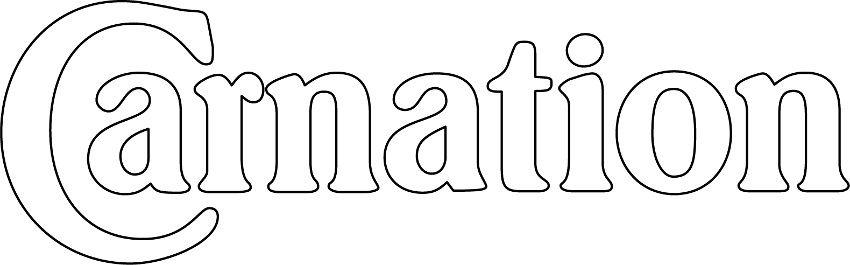

In [26]:
from IPython.display import Image, display_jpeg

display_jpeg(Image(file_list[0]))

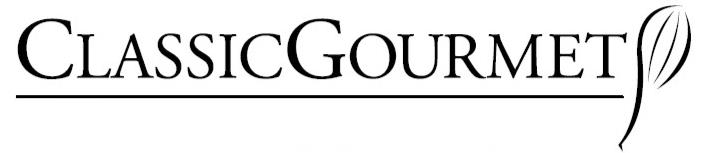

In [27]:
display_jpeg(Image(file_list[1316]))

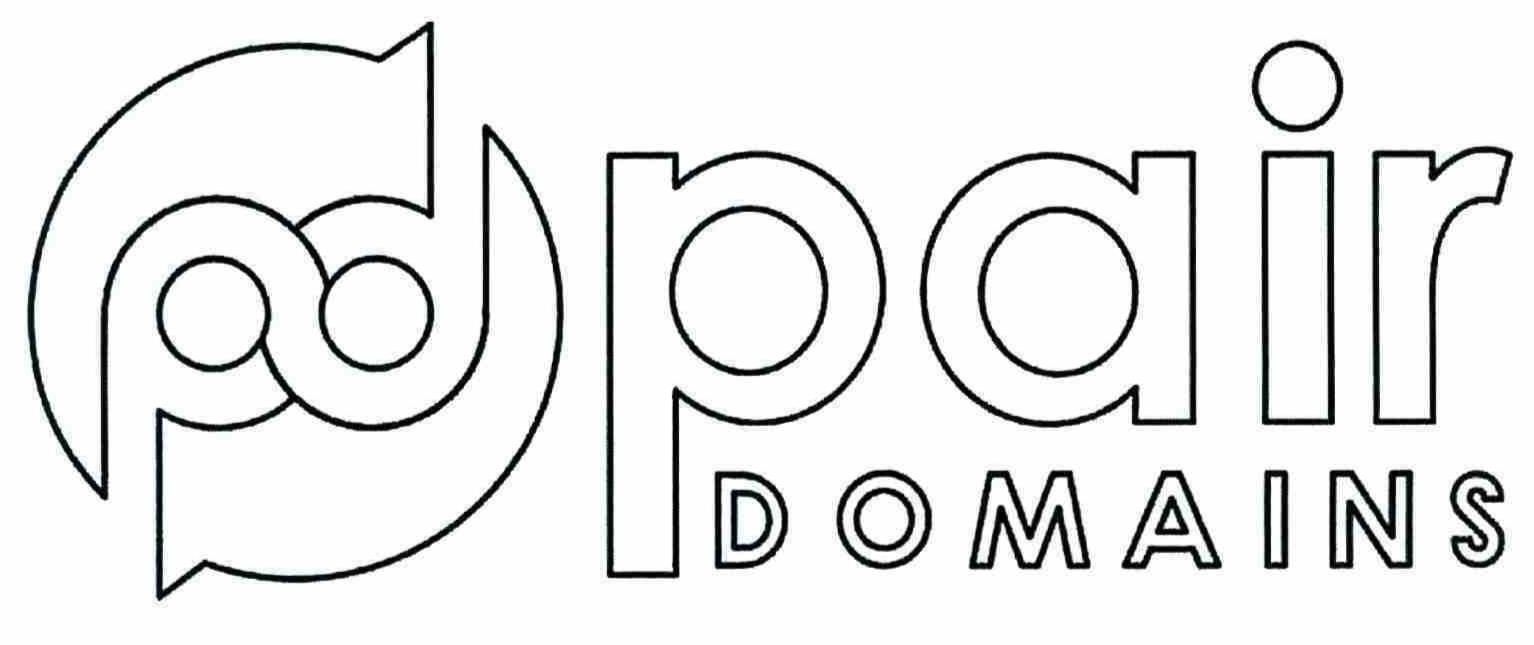

In [28]:
display_jpeg(Image(file_list[5138]))

Another example.

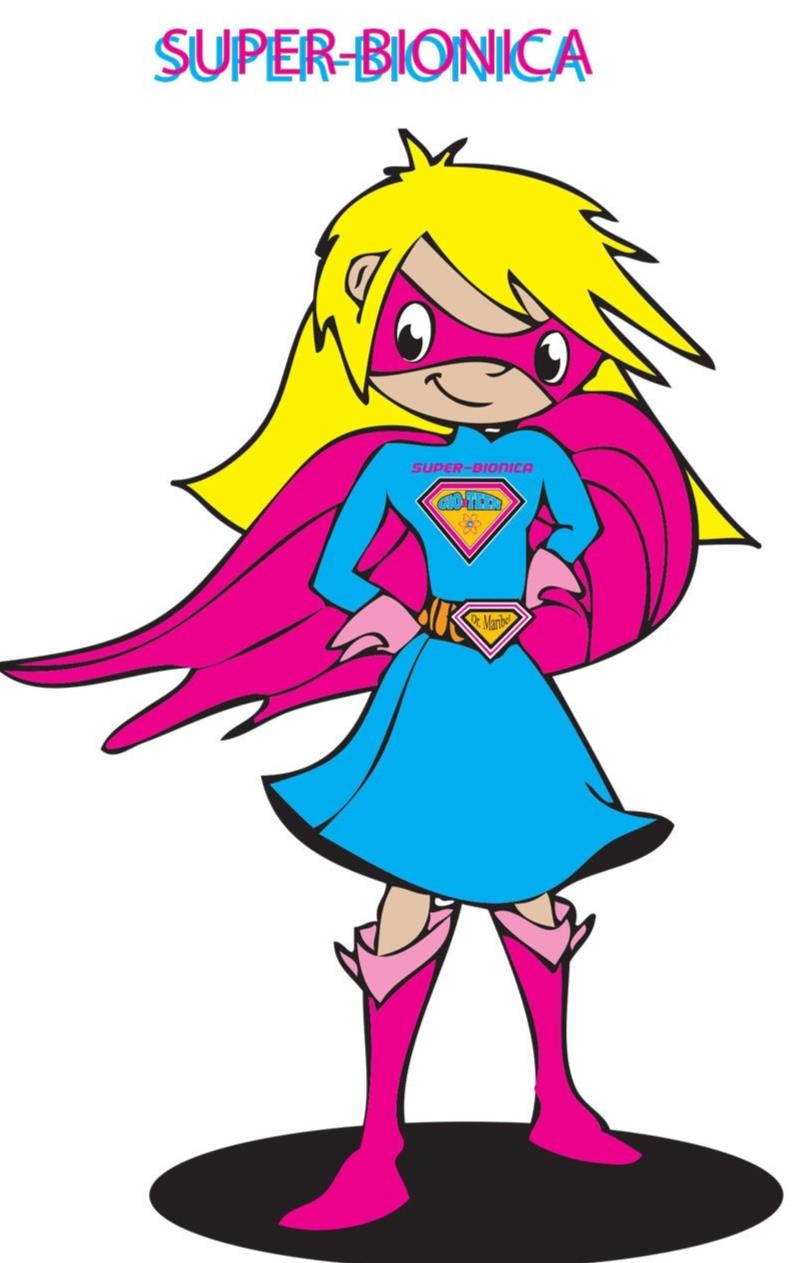

In [29]:
display_jpeg(Image(file_list[4005]))

In [30]:
result = search_by_image(predict_one_img(model,file_list[4005]), index, features)

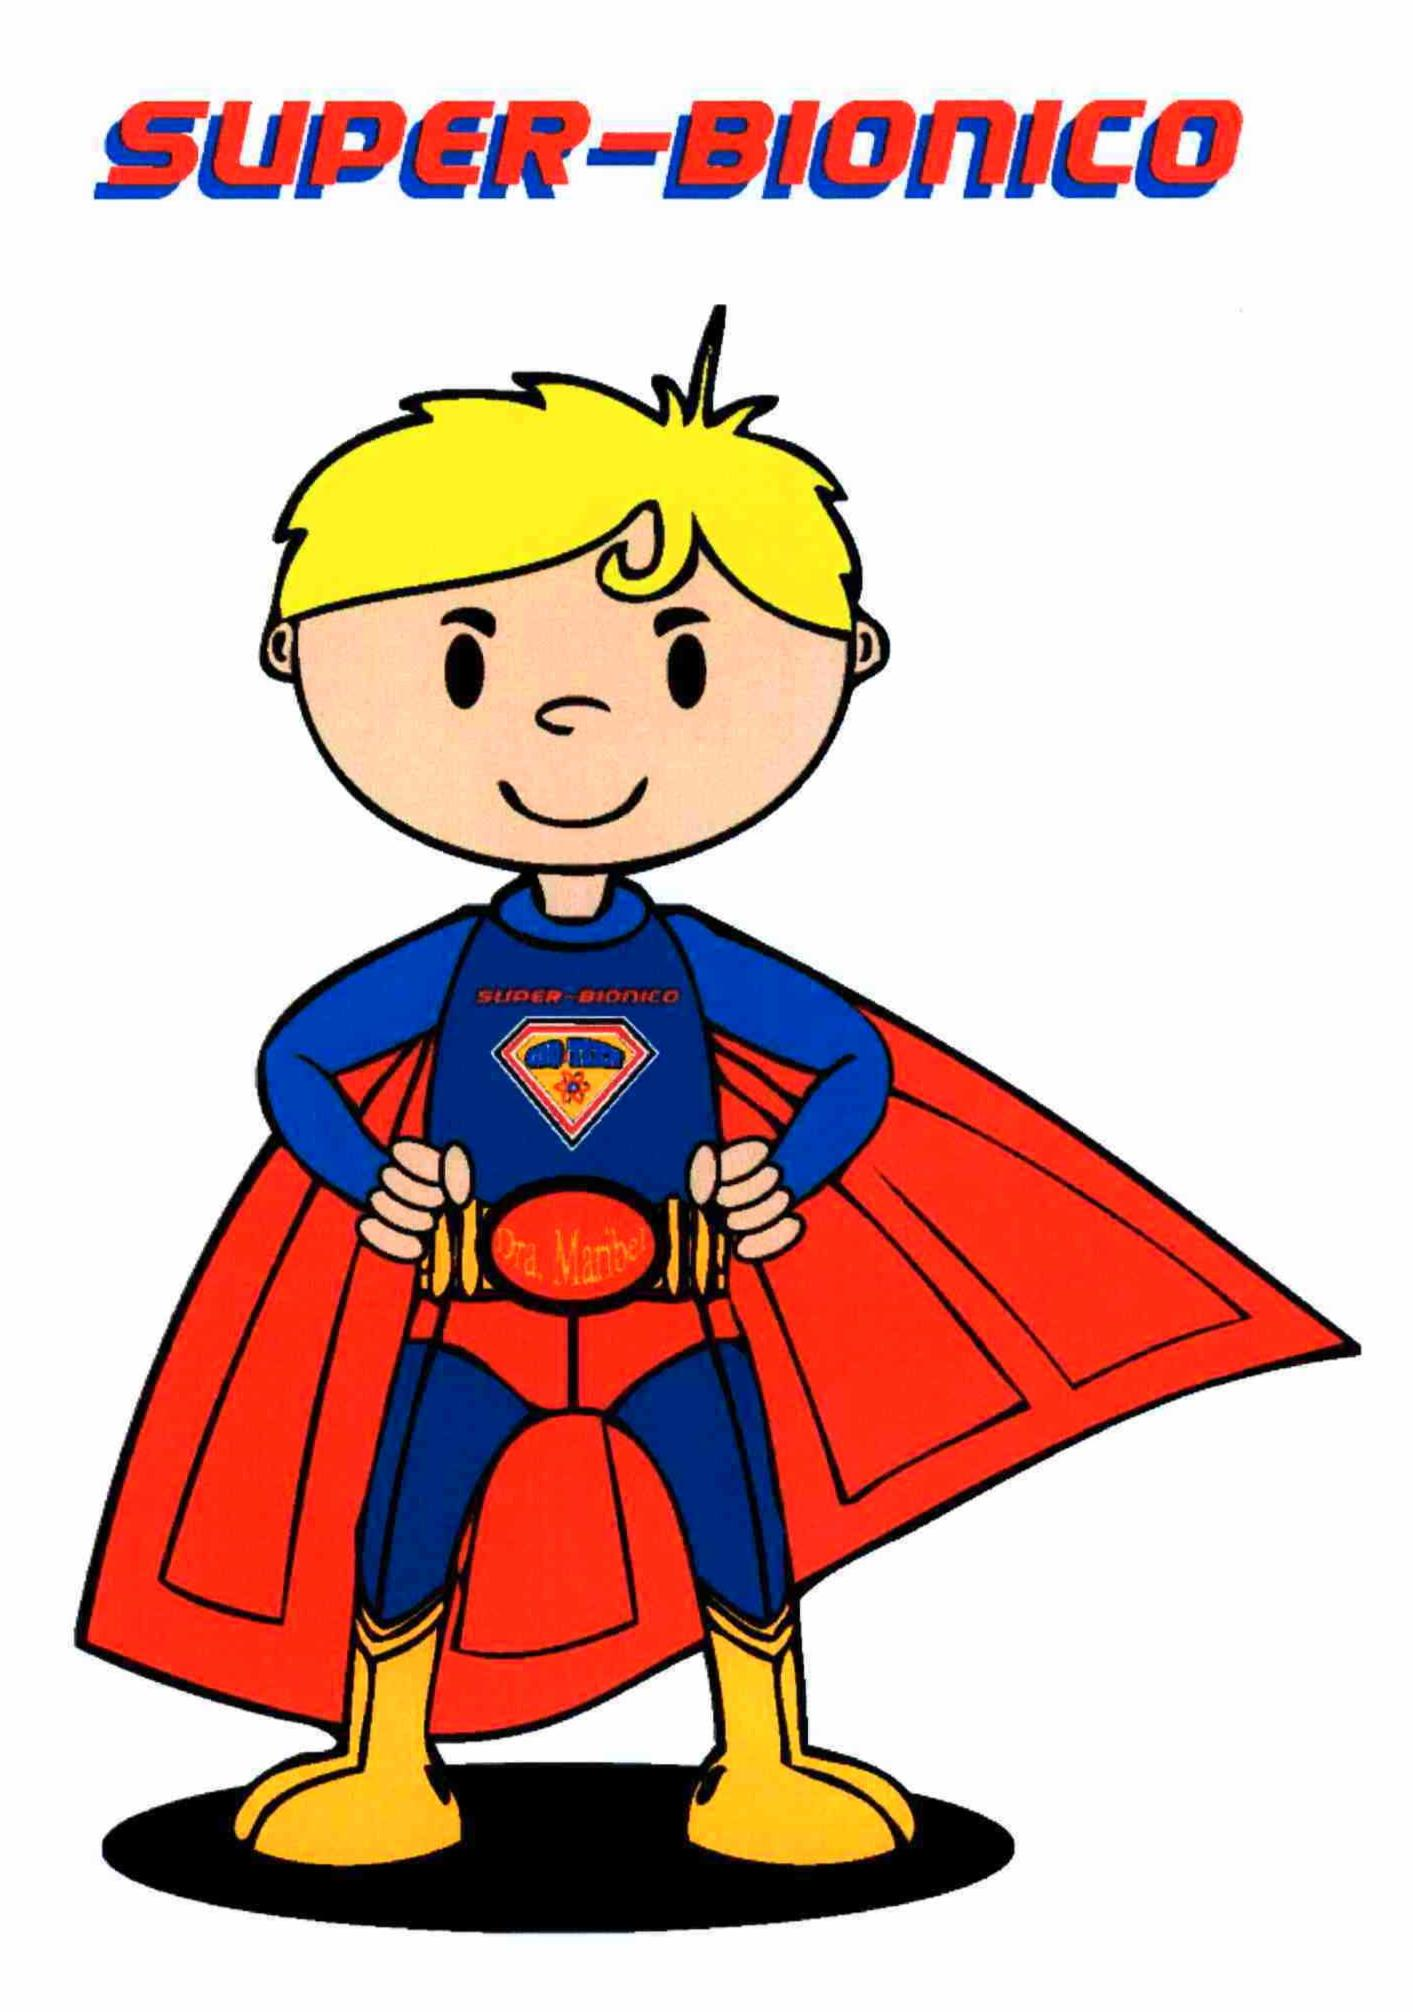

In [31]:
display_jpeg(Image(file_list[result[0][1]]))

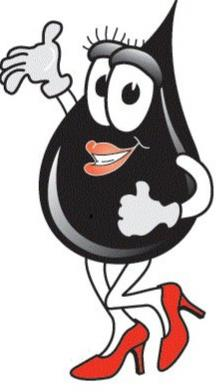

In [32]:
display_jpeg(Image(file_list[result[0][2]]))

## Simple classification

In [8]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

In [9]:
img_path = '/work/data/images/71017330.jpg'

In [10]:
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n03532672', 'hook', 0.25856137), ('n04275548', 'spider_web', 0.095146634), ('n03291819', 'envelope', 0.056449067)]


In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)